# 2D Pose Estimation and 3D Pose Estimation from Image


image 1/1 c:\Users\17346\src\ergo\worker.jpg: 448x640 1 person, 26.0ms
Speed: 2.1ms preprocess, 26.0ms inference, 7.0ms postprocess per image at shape (1, 3, 448, 640)


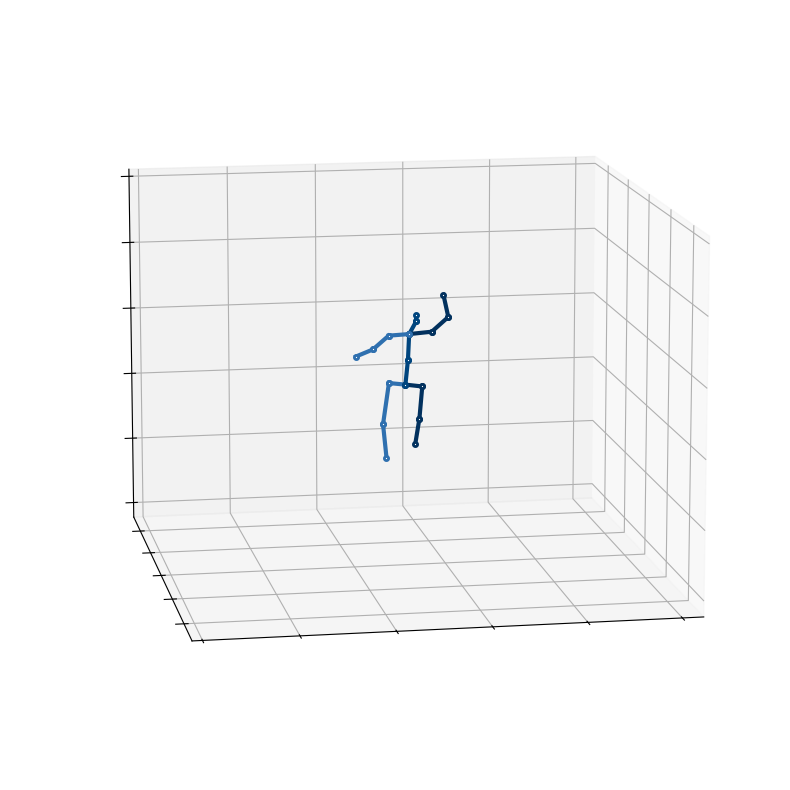

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn

from functools import partial
from PIL import Image
from torchvision.transforms.functional import pil_to_tensor
from ultralytics import YOLO

import utils
from data.utils import coco2h36m, draw_2d_pose_from_image
from models.motionBERT import DSTformer, get_config, render_and_save

device = 'cuda' if torch.cuda.is_available() else 'cpu'

image = "worker.jpg"
image_filename = utils.get_filename(image)

pose2d_model = YOLO('yolov8n-pose.pt')
keypoints = pose2d_model(image)[0].keypoints.cpu().numpy() # shape (num_humans, 17, 3), COCO format
keypoints = coco2h36m(keypoints.data) # shape (num_humans, 17, 3), H36M format
show_pose2d = draw_2d_pose_from_image(image, keypoints, os.path.join("./output", "2d_pose_"+image_filename))

image_tensor = pil_to_tensor(Image.open(image)).permute(1, 2, 0).to(device) # shape (Hight, Width, Channels)
H, W = image_tensor.shape[0], image_tensor.shape[1]

pose3d_model = DSTformer(dim_in=3, dim_out=3, dim_feat=512, dim_rep=512,
                         depth=5, num_heads=8, mlp_ratio=2, norm_layer=partial(nn.LayerNorm, eps=1e-6),
                         maxlen=243, num_joints=17).to(device)
pose3d_model = nn.DataParallel(pose3d_model)

config = "models/pt/MB_ft_h36m.yaml"
checkpoint = "models/pt/MB_best_epoch.bin"
args = get_config(config)
checkpoint = torch.load(checkpoint, map_location=lambda storage, loc: storage)
pose3d_model.load_state_dict(checkpoint["model_pos"], strict=True)
pose3d_model.eval()

scale = min(W,H) / 2.0
keypoints[:,:,:2] = keypoints[:,:,:2] - np.array([W, H]) / 2.0
keypoints[:,:,:2] = keypoints[:,:,:2] / scale
keypoints_3D = keypoints.astype(np.float32)[0] # shape (1, 17, 3), single worker 

with torch.no_grad():
    keypoints_3D = torch.from_numpy(np.expand_dims(np.expand_dims(keypoints_3D, axis=0), axis=0)).to(device)
    predicted_3d = pose3d_model(keypoints_3D).squeeze(0).cpu().detach().numpy() # shape (1, 17, 3)
    render_and_save(predicted_3d, save_path=os.path.join("./output", "3d_pose_"+image_filename.split(".")[0]+".png"))
    np.save(os.path.join("./output", "3d_pose_"+image_filename.split(".")[0]+".npy"), predicted_3d)

# Ergonomic Risk Assessment (REBA/OWAS)

In [16]:
import pandas as pd
from ergonomics.reba import RebaScore
from ergonomics.owas import OwasScore
from data.utils import h36m2rcoco

# predicted_3d = np.load("../output/3D_pose_worker.npy")
pose = np.squeeze(h36m2rcoco(predicted_3d))
right_rebaScore = RebaScore()
left_rebaScore = RebaScore()

right_REBA_body_params = right_rebaScore.get_body_angles_from_pose_right(pose)
right_REBA_arms_params = right_rebaScore.get_arms_angles_from_pose_right(pose)

left_REBA_body_params = left_rebaScore.get_body_angles_from_pose_left(pose)
left_REBA_arms_params = left_rebaScore.get_arms_angles_from_pose_left(pose)

right_rebaScore.set_body(right_REBA_body_params)
left_rebaScore.set_body(left_REBA_body_params)
right_score_a, right_partial_a = right_rebaScore.compute_score_a()
left_score_a, left_partial_a = left_rebaScore.compute_score_a()

right_rebaScore.set_arms(right_REBA_arms_params)
left_rebaScore.set_arms(left_REBA_arms_params)

right_score_b, right_partial_b = right_rebaScore.compute_score_b()
left_score_b, left_partial_b = left_rebaScore.compute_score_b()

right_score_c, right_caption = right_rebaScore.compute_score_c(right_score_a, right_score_b)
left_score_c, left_caption = left_rebaScore.compute_score_c(left_score_a, left_score_b)

REBA_summary = {
    "Right Score A": [right_score_a],
    "Right Score B": [right_score_b],
    "Right Score C": [right_score_c],
    "Left Score A" : [left_score_a],
    "Left Score B" : [left_score_b],
    "Left Score C" : [left_score_c],
    "Right Score A (Neck)": [right_partial_a[0]],
    "Right Score A (Trunk)": [right_partial_a[1]],
    "Right Score A (R Leg)": [right_partial_a[2]],
    "Right Score B (R UpperArm)": [right_partial_b[0]],
    "Right Score B (R LowerArm)": [right_partial_b[1]],
    "Right Score B (R Wrist)": [right_partial_b[2]],
    "Left Score A (Neck)": [left_partial_a[0]],
    "Left Score A (Trunk)": [left_partial_a[1]],
    "Left Score A (L Leg)": [left_partial_a[2]],
    "Left Score B (L UpperArm)": [left_partial_b[0]],
    "Left Score B (L LowerArm)": [left_partial_b[1]],
    "Left Score B (L Wrist)": [left_partial_b[2]],
}
REBA_table = pd.DataFrame(REBA_summary).T.rename(columns={0:""})

print("="*10+"REBA Result"+"="*10)
print(right_caption) if right_score_c > left_score_c else print(left_caption)
print(REBA_table)

print("\n"+"="*10+"OWAS Result"+"="*10)
owasScore = OwasScore()
OWAS_body_params = owasScore.get_param_from_pose(pose, verbose=False)
owasScore.set_body_params(OWAS_body_params)
owas_score, partial_score = owasScore.compute_score()

print("Owas Score:", owas_score)
print("Trunk, Arms, Legs, Load :", partial_score)

==========REBA Result==========
High Risk. Investigate and Implement Change
                              
Right Score A                9
Right Score B                5
Right Score C               10
Left Score A                 6
Left Score B                 7
Left Score C                 9
Right Score A (Neck)         3
Right Score A (Trunk)        5
Right Score A (R Leg)        3
Right Score B (R UpperArm)   4
Right Score B (R LowerArm)   2
Right Score B (R Wrist)      1
Left Score A (Neck)          2
Left Score A (Trunk)         3
Left Score A (L Leg)         3
Left Score B (L UpperArm)    5
Left Score B (L LowerArm)    2
Left Score B (L Wrist)       1

==========OWAS Result==========
Owas Score: 1
Trunk, Arms, Legs, Load : [3 1 6 1]
